<a href="https://colab.research.google.com/github/Samarth-991/Deep-Learning/blob/master/27_Helmet_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Safety Helmet detection
Improve workplace safety by detecting people and hard hats on 5k images with bbox annotations.



In [ ]:
# !pip install -U torch torchvision
# !pip install git+https://github.com/facebookresearch/fvcore.git
# !pip install pyyaml==5.1
# !pip install imgaug==0.2.5
# !git clone https://github.com/facebookresearch/detectron2 detectron2_repo
# !pip install -e detectron2_repo

In [ ]:
# !pip install kaggle
# !pip install tpot
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d andrewmvd/hard-hat-detection
# !unzip /content/hard-hat-detection.zip

In [ ]:
import os
import glob
import urllib
from PIL import Image
import pandas as pd
import numpy as np
import random
import itertools
from collections import Counter , defaultdict
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch, torchvision
print (torch.__version__)
%matplotlib inline
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor,DefaultTrainer
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import MetadataCatalog, DatasetCatalog , build_detection_test_loader

1.6.0+cu101


In [ ]:
#! mv images Helmets
Helmets = '/content/Helmets'
Annotations = '/content/annotations'

In [ ]:
print ("total number of images :",len(glob.glob(Helmets+'/*.png')))

if len(glob.glob(Helmets+'/*.jpg')) != len(glob.glob(Helmets+'/*.xml')):
  print ("images and XML are not equal length")

total number of images : 5000


In [ ]:
import xml.etree.ElementTree as ET

def xml_to_csv(path):
  xml_list = []
  for xml_file in glob.glob(path + '/*.xml'):
      tree = ET.parse(xml_file)
      root = tree.getroot()
      for member in root.findall('object'):
          value = (root.find('filename').text,
                    int(root.find('size')[0].text),
                    int(root.find('size')[1].text),
                    member[0].text,
                    int(member[5][0].text),
                    int(member[5][1].text),
                    int(member[5][2].text),
                    int(member[5][3].text)
                    )
          xml_list.append(value)
  column_name = ['file_name', 'width', 'height',
                'class_name', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=column_name)
  return xml_df

CLASS_NAME = 'Helmets'
XML_dataframe = xml_to_csv(Annotations)
XML_dataframe

,file_name,width,height,class_name,xmin,ymin,xmax,ymax
0,hard_hat_workers472.png,416,415,helmet,106,207,124,228
1,hard_hat_workers472.png,416,415,helmet,44,213,65,235
2,hard_hat_workers472.png,416,415,helmet,160,221,179,238
3,hard_hat_workers472.png,416,415,helmet,287,231,304,248
4,hard_hat_workers3474.png,416,416,helmet,290,108,349,175
...,...,...,...,...,...,...,...,...
25497,hard_hat_workers2318.png,416,415,helmet,291,96,309,117
25498,hard_hat_workers2318.png,416,415,helmet,124,410,149,414
25499,hard_hat_workers2318.png,416,415,helmet,291,22,309,43
25500,hard_hat_workers3025.png,416,416,helmet,226,15,274,74


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


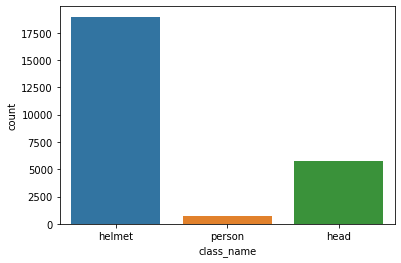

In [ ]:
import seaborn as sns
sns.countplot(XML_dataframe['class_name'])

In [ ]:
#Helmet_df = XML_dataframe[XML_dataframe['class']=='helmet']
Helmet_df = XML_dataframe

In [ ]:
def get_bboxes(df,id):
    bboxes = []
    x_min= int(df.xmin.to_numpy()[id][0])
    y_min = int(df.ymin.to_numpy()[id][0])
    x_max = int(df.xmax.to_numpy()[id][0])
    y_max = int(df.ymax.to_numpy()[id][0])
    w = x_max - x_min
    h = y_max -y_min
    bboxes.append([x_min, y_min,w, h])
    return bboxes

def plot_image_examples(dataframe, rows=3, cols=3, title='Image examples'):
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))  
    for row in range(rows):
      for col in range(cols):
          ix = np.random.randint(len(dataframe), size=1)
          filename = dataframe.file_name.to_numpy()[ix]
          img = Image.open(os.path.join(Helmets,filename[0]))
          bboxes = get_bboxes(dataframe,ix)
          for bbox in bboxes:
            rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
            axs[row, col].add_patch(rect)
          axs[row, col].imshow(img)


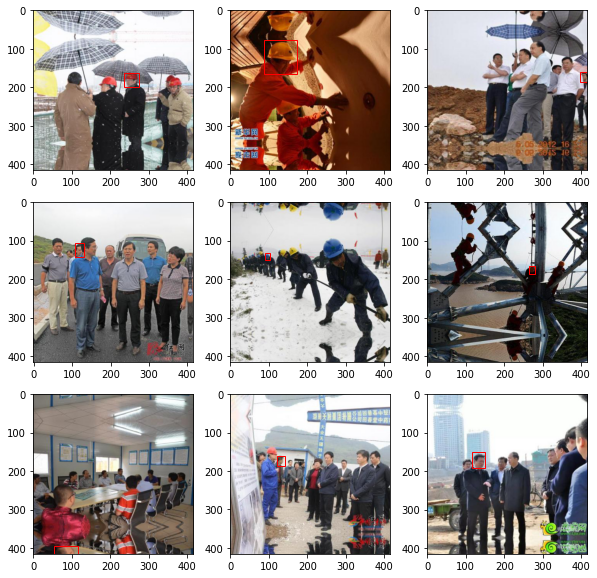

In [ ]:
plot_image_examples(Helmet_df)
#Helmet_df['class_name']='helmet'

In [ ]:
unique_files = Helmet_df.file_name.unique()
train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.90), replace=False))
train_df = Helmet_df[Helmet_df.file_name.isin(train_files)]
test_df = Helmet_df[~Helmet_df.file_name.isin(train_files)]

print(len(train_df))
print(len(test_df))

22976
2526


In [ ]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.xmin)
      ymin = int(row.ymin)
      xmax = int(row.xmax)
      ymax = int(row.ymax)

      poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
train_name = 'helmet_'
for d in ["train", "val"]:
  DatasetCatalog.register(train_name + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get(train_name + d).set(thing_classes=['helmet'])

statement_metadata = MetadataCatalog.get(train_name+'train')

In [ ]:
print (statement_metadata.name)
classes = Helmet_df.class_name.unique().tolist()
print(classes)

helmet_train
['helmet', 'person', 'head']


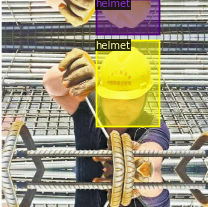

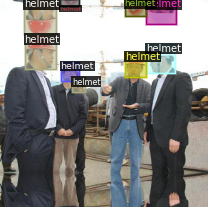

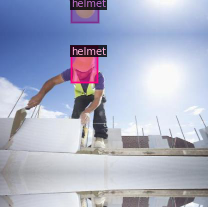

In [ ]:
import random
IMAGES_PATH = f'Helmets'

dataset_dicts = create_dataset_dicts(train_df,classes)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=statement_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
cfg = get_cfg()

#cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

In [ ]:
cfg.DATASETS.TRAIN = (statement_metadata.name.split('_')[0]+"_train",)
cfg.DATASETS.TEST = (statement_metadata.name.split('_')[0]+"_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05
print(cfg.DATASETS.TRAIN)
print(cfg.DATASETS.TEST)

('helmet_train',)
('helmet_val',)


In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 20
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 50

In [ ]:
! rm -rf /content/output 
!rm -rf /content/coco_eval
# remove this directory , as detectron save cache else
# AssertionError: Results do not correspond to current coco set

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[09/06 17:52:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (3, 256, 1, 1) 

[09/06 17:52:46 d2.engine.train_loop]: Starting training from iteration 0


/content/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/content/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzer

[09/06 17:54:37 d2.utils.events]:  eta: 0:25:33  iter: 19  total_loss: 3.046  loss_cls: 1.366  loss_box_reg: 0.6113  loss_mask: 0.6893  loss_rpn_cls: 0.2493  loss_rpn_loc: 0.03943  time: 5.5017  data_time: 0.0455  lr: 1.9981e-05  max_mem: 7464M
[09/06 17:56:27 d2.utils.events]:  eta: 0:24:12  iter: 39  total_loss: 2.941  loss_cls: 1.201  loss_box_reg: 0.673  loss_mask: 0.6699  loss_rpn_cls: 0.283  loss_rpn_loc: 0.04836  time: 5.5015  data_time: 0.0233  lr: 3.9961e-05  max_mem: 7464M
[09/06 17:57:22 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   helmet   | 1928         |
|            |              |
[09/06 17:57:22 d2.data.common]: Serializing 500 elements to byte tensors and concatenating them all ...
[09/06 17:57:22 d2.data.common]: Serialized dataset takes 0.24 MiB
[09/06 17:57:22 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, 

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator(train_name+"val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, train_name+"val")
inference_on_dataset(trainer.model, val_loader, evaluator)

[09/06 18:54:01 d2.data.common]: Serializing 500 elements to byte tensors and concatenating them all ...
[09/06 18:54:01 d2.data.common]: Serialized dataset takes 0.24 MiB
[09/06 18:54:01 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/06 18:54:01 d2.evaluation.evaluator]: Start inference on 500 images
[09/06 18:54:09 d2.evaluation.evaluator]: Inference done 11/500. 0.6174 s / img. ETA=0:05:08
[09/06 18:54:14 d2.evaluation.evaluator]: Inference done 19/500. 0.6195 s / img. ETA=0:05:05
[09/06 18:54:19 d2.evaluation.evaluator]: Inference done 27/500. 0.6195 s / img. ETA=0:05:01
[09/06 18:54:24 d2.evaluation.evaluator]: Inference done 35/500. 0.6194 s / img. ETA=0:04:56
[09/06 18:54:29 d2.evaluation.evaluator]: Inference done 43/500. 0.6190 s / img. ETA=0:04:50
[09/06 18:54:34 d2.evaluation.evaluator]: Inference done 51/500. 0.6194 s / img. ETA=0:04:45
[09/06 18:54:39 d2.evaluation.evalua

OrderedDict([('bbox',
              {'AP': 45.395328998603595,
               'AP50': 84.92982646215923,
               'AP75': 43.59613139123045,
               'APl': 58.364837648049736,
               'APm': 53.45238882229791,
               'APs': 35.34725541725777}),
             ('segm',
              {'AP': 40.57112229320307,
               'AP50': 83.67038619980906,
               'AP75': 32.38654775793109,
               'APl': 44.213852239857914,
               'APm': 46.84816080944479,
               'APs': 33.094882522199306})])

In [ ]:
os.makedirs("annotated_results", exist_ok=True)
from detectron2.utils.visualizer import Visualizer, ColorMode
import ntpath

test_image_paths = test_df.file_name.unique()
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata,
    scale=1.,
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

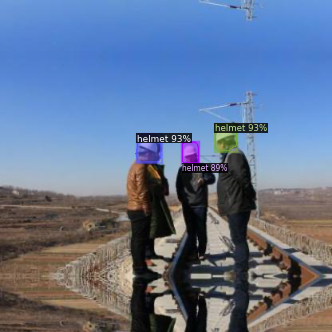

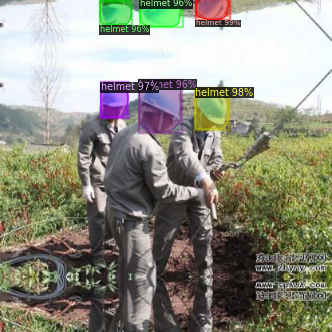

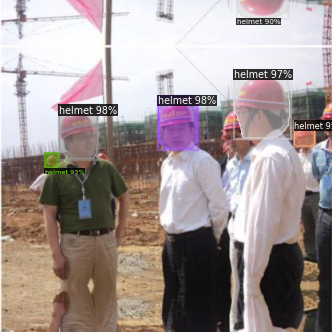

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts_infer = create_dataset_dicts(train_df,classes)

for d in random.sample(dataset_dicts_infer, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=statement_metadata, 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

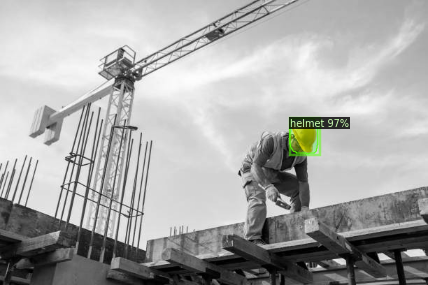

In [ ]:
from detectron2.utils.visualizer import ColorMode

cfg.MODEL.WEIGHTS =  "/content/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

im = cv2.imread('/content/istockphoto-897664288-612x612.jpg')
#im = cv2.resize(im,(416,416))
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
              metadata=statement_metadata, 
              scale=0.7, 
             instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])